In [1]:
import torch
import sys
import os
import time
import numpy as np
import argparse
sys.path.append("..")

from torch.utils.data import DataLoader
from torch.utils.data import WeightedRandomSampler
from umap.umap_ import find_ab_params

from singleVis.custom_weighted_random_sampler import CustomWeightedRandomSampler
from singleVis.SingleVisualizationModel import VisModel
from singleVis.losses import UmapLoss, ReconstructionLoss, SingleVisLoss
from singleVis.edge_dataset import DataHandler
from singleVis.trainer import SingleVisTrainer
from singleVis.data import NormalDataProvider
from singleVis.spatial_edge_constructor import kcSpatialAlignmentEdgeConstructor
# from singleVis.temporal_edge_constructor import GlobalTemporalEdgeConstructor
from singleVis.alignment_edge_constructor import LocalAlignmentEdgeConstructor
from singleVis.projector import TimeVisProjector
from singleVis.eval.evaluator import Evaluator


import torch
import numpy as np
from CKA import CKA, CudaCKA

/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CLEAN_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"
CONTENT_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy0.001"
REF_PATH = "/home/yifan/dataset/noisy/pairflip/cifar10/reference/"

NOISY500 = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy500"
NOISY2500 = "/home/yifan/dataset/noisy/pairflip/cifar10/noisy2500"
NOISY20 = "/home/yifan/dataset/noisy/pairflip/cifar10/20"
NOISY0 = "/home/yifan/dataset/noisy/pairflip/cifar10/0"
sys.path.append(REF_PATH)
sys.path.append(CONTENT_PATH)

from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


from config import config

ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)

data_provider = NormalDataProvider(CONTENT_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
# REFERENCE
noisy_data_provider = NormalDataProvider(NOISY0,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1 )
noisy2500_data_provider = NormalDataProvider(NOISY2500,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1 )
clean_data_provider = NormalDataProvider(CLEAN_PATH,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1  )
clean_data = clean_data_provider.train_representation(200).squeeze()

ref_train_data = ref_provider.train_representation(200).squeeze()

# EPOCH 200
train_data = data_provider.train_representation(200).squeeze()
# EPOCH 199
# prev_train_data = data_provider.train_representation(199).squeeze()

noisy_data = noisy_data_provider.train_representation(200).squeeze()

Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...
Finish initialization...


In [5]:
from torch import nn


import scipy
import numpy as np
from sklearn.cross_decomposition import CCA

model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

# Step1: Computing the loss 
def compute_loss(X,Y,R):
    '''
     The loss function will be the squared Frobenoius norm of the difference between the matrix and its approximation, divided by the number of training examples m
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
        L: a matrix of dimension (m,n) -the value of the loss function for given X, Y and R
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    m = len(X)
    Xnew = np.dot(X, R)
    # Ynew = np.dot(Y, R)
    # diff is Projector(XR) - Projector(Y) 
    Y_2d = projector.batch_project(200, Y)
    X_2d = projector.batch_project(200, Xnew)
    Euclid = 0
    for i in range(m):
        d = ((X_2d[i][0] - Y_2d[i][0])**2 + (X_2d[i][1] - Y_2d[i][1])**2)**0.5
        Euclid = Euclid + d
    
    print('Euclid',Euclid/m)
    

    # Xnew = np.dot(X, R)

    # print("Euclid:",np.sqrt(np.sum(np.square(projector.batch_project(200, Y)-projector.batch_project(200, np.dot(X, R))))))
    # print("Euclid:",np.sqrt(np.sum(np.square(projector.batch_project(200, Y)-projector.batch_project(200, np.dot(X, R))))))
    diff = projector.batch_project(200, np.dot(X, R)) - projector.batch_project(200, Y)

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss


# Step2: Computing the loss 
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)
    # Xnew = np.dot(X, R)


    # Y_2d = projector.batch_project(200, Y)
    # X_2d = projector.batch_project(200, Xnew)
    rows, columns = X.shape

    # Euclid = 0
    # for i in range(m):
    #     d = ((X_2d[i][0] - Y_2d[i][0])**2 + (X_2d[i][1] - Y_2d[i][1])**2)**0.5
    #     Euclid = Euclid + d
    
    # print('Euclid',Euclid/m)

    # diff = projector.batch_project(200, np.dot(X, R)) - projector.batch_project(200, Y)

    # # diff_squared is the element-wise square of the difference
    # diff_squared = diff**2

    # # sum_diff_squared is the sum of the squared elements
    # sum_diff_squared = diff_squared.sum()

    # loss = sum_diff_squared/m
    # gradient is X^T(XR - Y) * 2/m
    # gradient = (np.dot(inv_X.T, np.dot(inv_X, R) - inv_Y))/rows
    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    # gradient = torch.autograd.grad(outputs = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows, inputs=torch.tensor(R), only_inputs=True, create_graph=True )
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient



# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps: int=4000,
                      learning_rate: float=0.0005,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        train_steps: positive int - describes how many steps will gradient descent algorithm do.
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])

    for i in range(train_steps):

        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)
       
        print(f"iteration {i}")
         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R

np.random.seed(129)
m = 10
n = 5
X = noisy2500_data_provider.train_representation(200).squeeze()
Y = data_provider.train_representation(200).squeeze()
R = align_embeddings(X, Y)


print(R)


iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
iteration 42
iteration 43
iteration 44
iteration 45
iteration 46
iteration 47
iteration 48
iteration 49
iteration 50
iteration 51
iteration 52
iteration 53
iteration 54
iteration 55
iteration 56
iteration 57
iteration 58
iteration 59
iteration 60
iteration 61
iteration 62
iteration 63
iteration 64
iteration 65
iteration 66
iteration 67
iteration 68
iteration 69
iteration 70
iteration 71
iteration 72
iteration 73
iteration 74
iteration 75
iteration 76
iteration

In [8]:
import json
filename = 'test.json'
with open(filename, 'w', encoding='utf-8') as file_obj:
    ll = json.dumps(R,ensure_ascii=False)
    file_obj.write(ll)

TypeError: Object of type ndarray is not JSON serializable

In [9]:
    Y_2d = projector.batch_project(200, np.dot(noisy2500_data_provider.train_representation(200).squeeze(),R))
    X_2d = projector.batch_project(200, data_provider.train_representation(200).squeeze())


    Euclid = 0
    for i in range(m):
        d = ((X_2d[i][0] - Y_2d[i][0])**2 + (X_2d[i][1] - Y_2d[i][1])**2)**0.5
        Euclid = Euclid + d
    
    print('Euclid',Euclid/m)

Euclid 2.2666624529469277


In [ ]:
###  ============================= caculate cca ============================== ###
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = np.dot(noisy2500_data,R)
Y = noisy2500_data
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('noisy20  epoch 1 vs epoch200 ')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

In [ ]:

model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=NOISY0, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer

vis = visualizer(noisy_data_provider, noisy_data, projector, 200, 'tab10')
# vis = visualizer(data_provider, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, np.dot(noisy_data,R), projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, noisy_data, projector, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
import numpy as np
clean_path = os.path.join(NOISY2500, 'clean_label.json')
with open(clean_path, "r") as f:
    clean_labels = np.array(json.load(f))
noisy_path = os.path.join(NOISY2500, 'noisy_label.json')
with open(noisy_path, "r") as f:
    noisy_labels = np.array(json.load(f))
noisy_indicates = []
clean_indicates = []
pairs = []
for i in range(len(clean_labels)):
    if clean_labels[i] != noisy_labels[i]:
        noisy_indicates.append(i)
        pairs.append({"clean":clean_labels[i],"noisy:": noisy_labels[i]})
    else:
        clean_indicates.append(i)
print(len(noisy_indicates))

In [ ]:
CLEAN = np.dot(noisy_data, R)
NOISY = np.dot(noisy2500_data, R2500)

CLEAN_2d = projector.batch_project(200, CLEAN)
NOISY_2d = projector.batch_project(200, NOISY)
EuclidClean = 0
EuclidNoisy = 0
noisy_num = len(noisy_indicates)
clean_num = len(clean_indicates)
for m in range(len(noisy_indicates)):
        i = noisy_indicates[m]
        d = ((CLEAN_2d[i][0] - NOISY_2d[i][0])**2 + (CLEAN_2d[i][1] - NOISY_2d[i][1])**2)**0.5
        EuclidNoisy = EuclidNoisy + d


for m in range(len(clean_indicates)):
        i = clean_indicates[m]
        d = ((CLEAN_2d[i][0] - NOISY_2d[i][0])**2 + (CLEAN_2d[i][1] - NOISY_2d[i][1])**2)**0.5
        EuclidClean = EuclidClean + d
# print('Euclid',Euclid/m)
print('clean distance:',EuclidClean/clean_num,'noisy distance:',EuclidNoisy/noisy_num,)
    

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, np.dot(noisy_data, R), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(data_provider, train_data, projector, noisy_indicates, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(clean_data_provider, np.dot(noisy_data,R), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [78]:
import json
import os
import numpy as np
clean_path = os.path.join(NOISY500, 'clean_label.json')
with open(clean_path, "r") as f:
    clean_labels = np.array(json.load(f))
noisy_path = os.path.join(NOISY500, 'noisy_label.json')
with open(noisy_path, "r") as f:
    noisy_labels = np.array(json.load(f))
# noisy_indicates = []
# clean_indicates = []
selected_indicated = []
# pairs = []
for i in range(len(clean_labels)):
    if noisy_labels[i] == 1 or noisy_labels[i] == 8:
        selected_indicated.append(i)
        # pairs.append({"clean":clean_labels[i],"noisy:": noisy_labels[i]})

print(len(selected_indicated))

10000


In [ ]:

projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
CLEAN_2d = projector.batch_project(200, np.dot(noisy_data,R))
NOISY_2d = projector.batch_project(200, np.dot(noisy2500_data,R2500))
low = []
high = []

for i in range(len(CLEAN_2d)):
    d = ((CLEAN_2d[i][0] - NOISY_2d[i][0])**2 + (CLEAN_2d[i][1] - NOISY_2d[i][1])**2)**0.5
    if d < 5:
        low.append(i)
    else:
        high.append(i)


print(len(low),len(high))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=NOISY2500, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer_cc import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(noisy_data_provider, noisy_data, projector, low, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 50/50 [00:00<00:00, 12843.90it/s]


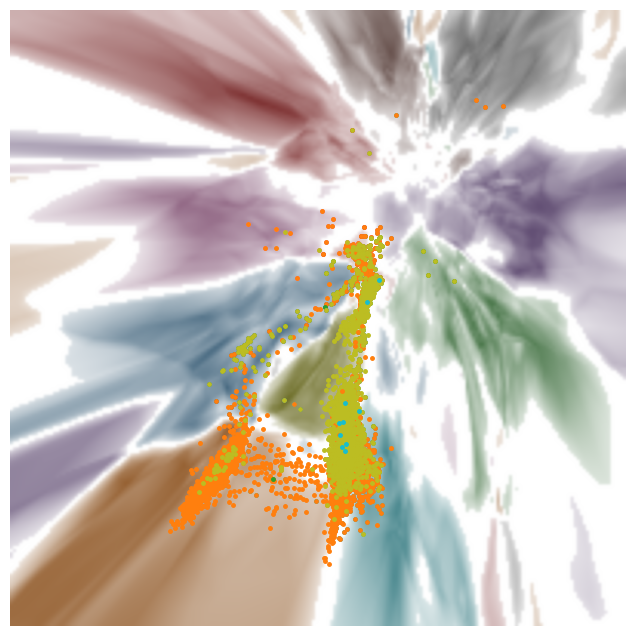

In [103]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(data_provider,data_provider.train_representation(10).squeeze(), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(10, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 50/50 [00:00<00:00, 13151.59it/s]


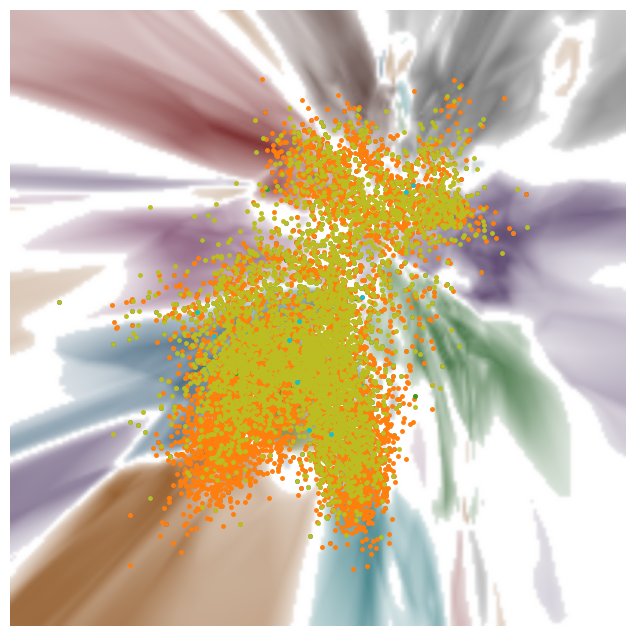

In [109]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CONTENT_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(data_provider,np.dot(noisy2500_data_provider.train_representation(10).squeeze(),R), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(10, path=os.path.join(save_dir, "origin_contrast"))

Computing decision regions ...


100%|██████████| 50/50 [00:00<00:00, 13131.82it/s]


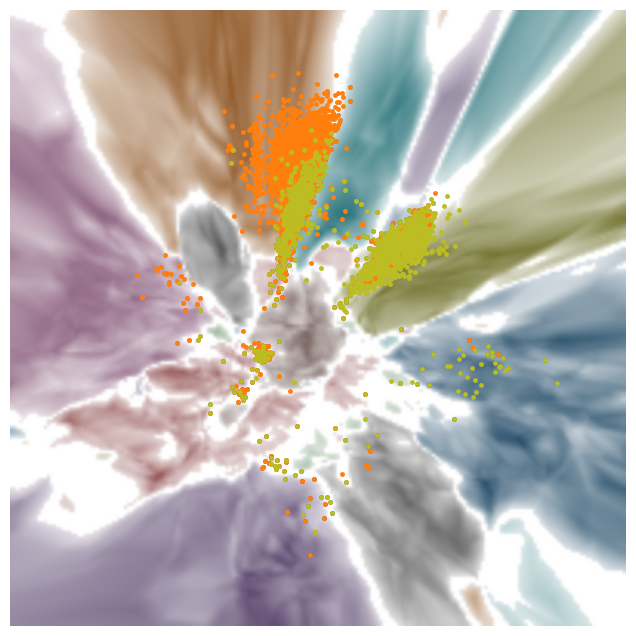

In [87]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=NOISY2500, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(noisy2500_data_provider,noisy2500_data_provider.train_representation(10).squeeze(), projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(10, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=CLEAN_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")
from representationTrans.r_visualizer import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(noisy_data_provider, noisy_data, projector, selected_indicated, 200, 'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))